<a href="https://colab.research.google.com/github/emnabt/ateliergit/blob/master/Copie_de_Optimisation_portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%writefile functions.py
print("hello")

Writing functions.py


In [ ]:
import pandas as pd
ind = pd.read_csv('/content/ind30_m_vw_rets.csv', header=0, index_col=0)/100
ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')

In [ ]:
ind.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,0.0056,-0.0519,0.0129,0.0293,0.1097,-0.0048,0.0808,0.0177,0.0814,0.0039,...,0.0083,0.0922,0.0206,0.0770,0.0193,-0.2379,0.0007,0.0187,0.0037,0.0520
1926-08,0.0259,0.2703,0.0650,0.0055,0.1001,-0.0358,-0.0251,0.0425,0.0550,0.0814,...,0.0217,0.0202,0.0439,-0.0238,0.0488,0.0539,-0.0075,-0.0013,0.0446,0.0676
1926-09,0.0116,0.0402,0.0126,0.0658,-0.0099,0.0073,-0.0051,0.0069,0.0533,0.0231,...,0.0241,0.0225,0.0019,-0.0554,0.0005,-0.0787,0.0025,-0.0056,-0.0123,-0.0386
1926-10,-0.0306,-0.0331,0.0106,-0.0476,0.0947,-0.0468,0.0012,-0.0057,-0.0476,0.0100,...,-0.0011,-0.0200,-0.0109,-0.0508,-0.0264,-0.1538,-0.0220,-0.0411,-0.0516,-0.0849
1926-11,0.0635,0.0729,0.0455,0.0166,-0.0580,-0.0054,0.0187,0.0542,0.0520,0.0311,...,0.0163,0.0377,0.0364,0.0384,0.0160,0.0467,0.0652,0.0433,0.0224,0.0400


```python
def get_ind_returns():
    """
    Load and format the Ken French 30 Industry Portfolios Value Weighted Monthly Returns
    """
    ind = pd.read_csv("/content/ind30_m_vw_rets.csv", header=0, index_col=0)/100
    ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')  #ligne
    ind.columns = ind.columns.str.strip() # extraire les colonnes en string et enlever les espaces 
    return ind
```

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import functions as fct
ind = fct.get_ind_returns()
ind.shape

(1110, 30)

```python
def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the wealth index, 
       the previous peaks, and 
       the percentage drawdown
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})

```                         


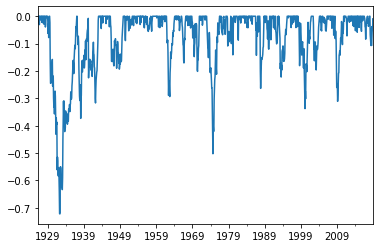

In [ ]:
fct.drawdown(ind["Food"])["Drawdown"].plot.line()

```python

from scipy.stats import norm
def var_gaussian(r, level=5, modified=False):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = skewness(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
    return -(r.mean() + z*r.std(ddof=0))

```    

In [ ]:
fct.var_gaussian(ind[["Food", "Beer", "Smoke"]], modified=True)

Food     0.061207
Beer     0.033881
Smoke    0.080292
dtype: float64

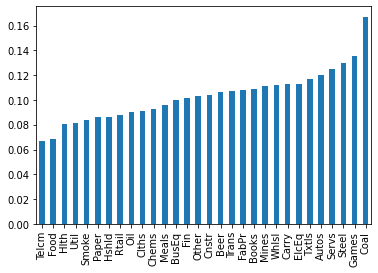

In [ ]:
fct.var_gaussian(ind).sort_values().plot.bar()

```python

def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol

```    

In [ ]:
fct.sharpe_ratio(ind, 0.03, 12).sort_values()

Coal     0.084275
Steel    0.126052
Whlsl    0.143494
Other    0.160862
Mines    0.177109
Books    0.192686
Games    0.194420
Txtls    0.194906
Trans    0.214624
Autos    0.227548
Cnstr    0.229351
FabPr    0.265297
Servs    0.267263
Fin      0.282243
Carry    0.285916
ElcEq    0.293063
Clths    0.293105
Util     0.306945
Hshld    0.307349
Oil      0.330358
Meals    0.332717
BusEq    0.342974
Chems    0.344903
Beer     0.351780
Rtail    0.364325
Paper    0.364722
Telcm    0.383294
Hlth     0.437783
Smoke    0.446361
Food     0.454770
dtype: float64

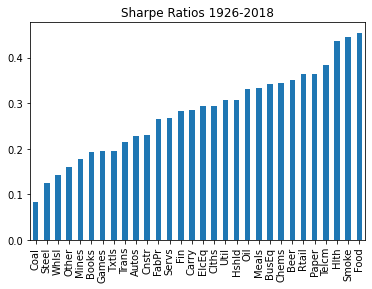

In [ ]:
fct.sharpe_ratio(ind, 0.03, 12).sort_values().plot.bar(title="Sharpe Ratios 1926-2018")

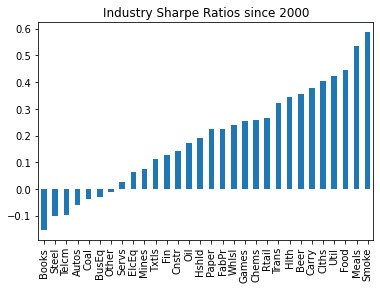

In [ ]:
fct.sharpe_ratio(ind["2000":], 0.03, 12).sort_values().plot.bar(title='Industry Sharpe Ratios since 2000')

```python
def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1

```

In [ ]:
er = fct.annualize_rets(ind["1995":"2000"], 12)

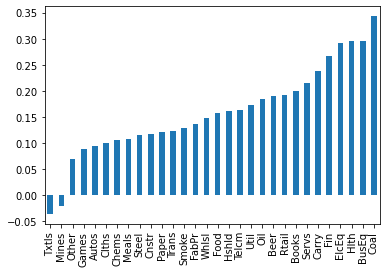

In [ ]:
er.sort_values().plot.bar()

covariance matrix

In [ ]:
cov = ind["1995":"2000"].cov()
cov.shape

(30, 30)

In [ ]:
cov

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
Food,0.002287,0.002077,0.001757,0.000701,0.000886,0.001208,0.001474,0.001105,0.001253,0.001021,...,0.000610,0.000211,-0.000280,0.001205,0.001312,0.000633,0.001165,0.001085,0.001839,0.000898
Beer,0.002077,0.004599,0.001143,0.001147,0.000765,0.002447,0.001415,0.001689,0.001292,0.001721,...,0.000978,0.000400,0.000028,0.001455,0.001974,0.000609,0.001442,0.001634,0.002236,0.001196
Smoke,0.001757,0.001143,0.007130,0.000296,-0.000099,0.000981,0.000761,0.000877,0.000687,0.000555,...,0.000057,-0.000266,-0.000300,0.001061,0.000241,0.001363,0.000069,0.000590,0.001117,0.001418
Games,0.000701,0.001147,0.000296,0.003271,0.001485,0.001018,0.001814,0.001219,0.001547,0.001291,...,0.001615,0.002399,0.002935,0.001615,0.001438,0.001681,0.001649,0.001383,0.002080,0.002088
Books,0.000886,0.000765,-0.000099,0.001485,0.002302,0.000876,0.002037,0.000657,0.001559,0.001362,...,0.001627,0.001996,0.001624,0.001481,0.001576,0.001205,0.001995,0.001026,0.001979,0.001283
Hshld,0.001208,0.002447,0.000981,0.001018,0.000876,0.002849,0.001046,0.001253,0.001226,0.001172,...,0.000889,0.001111,0.000906,0.001594,0.001366,0.000578,0.001157,0.001076,0.001652,0.001322
Clths,0.001474,0.001415,0.000761,0.001814,0.002037,0.001046,0.004896,0.000759,0.002547,0.002105,...,0.001263,0.001401,0.000746,0.002683,0.002466,0.001654,0.002607,0.002229,0.002699,0.001974
Hlth,0.001105,0.001689,0.000877,0.001219,0.000657,0.001253,0.000759,0.002252,0.000444,0.000538,...,0.001093,0.001390,0.001264,0.000552,0.000880,0.000907,0.000770,0.000900,0.001412,0.001099
Chems,0.001253,0.001292,0.000687,0.001547,0.001559,0.001226,0.002547,0.000444,0.002944,0.001705,...,0.000860,0.001072,0.000935,0.002581,0.001966,0.001257,0.001661,0.001425,0.002143,0.001832
Txtls,0.001021,0.001721,0.000555,0.001291,0.001362,0.001172,0.002105,0.000538,0.001705,0.002882,...,0.000790,0.000582,0.000685,0.001869,0.001760,0.001426,0.001696,0.001126,0.001789,0.001668


Tracer Efficient Frontier

1/recuperer les rendements
2/generer la matrice de cov

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import functions as fct

ind = fct.get_ind_returns()
er = fct.annualize_rets(ind["1996":"2000"], 12)
cov = ind["1996":"2000"].cov()

In [ ]:
er.head()

Food     0.116799
Beer     0.141126
Smoke    0.107830
Games    0.068212
Books    0.187286
dtype: float64

In [ ]:
er

Food     0.116799
Beer     0.141126
Smoke    0.107830
Games    0.068212
Books    0.187286
Hshld    0.134766
Clths    0.079160
Hlth     0.246641
Chems    0.077456
Txtls   -0.042721
Cnstr    0.084076
Steel    0.115809
FabPr    0.108280
ElcEq    0.272420
Autos    0.080954
Carry    0.173904
Mines   -0.053554
Coal     0.414689
Oil      0.165377
Util     0.145903
Telcm    0.122771
Servs    0.175264
BusEq    0.271952
Paper    0.097163
Trans    0.071099
Whlsl    0.126431
Rtail    0.207247
Meals    0.067400
Fin      0.223371
Other    0.043349
dtype: float64

In [ ]:
er[0]

0.11679867294226098

In order to find the **optimal weights**, we need a function that will** minimize the volatility** for a given **level of return**.
Trouver les poids qui minimise la volatility  pour un rendement donnée

```python
def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns

```



```python
def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    return (weights.T @ covmat @ weights)**0.5

```

```python
from scipy.optimize import minimize

# retourne un vecteur de  poids avec un min de vol avec un rendement donnée
def minimize_vol(target_return, er, cov):
    """
    Returns the optimal weights that achieve the target return
    given a set of expected returns and a covariance matrix
    """
    n = er.shape[0] // nb des actifs
    init_guess = np.repeat(1/n, n)  // supposition initiale 
    # les poids varient entre 0 et 1
    bounds = ((0.0, 1.0),) * n # pour chaque actifs
    # construct the constraints
    # il faut que les poids trouvé par l'optimizer doit satissfait ces conditions
    # somme des pods egale a 1 
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    #le rendement qu'on produise a partir de l'ensemble des poids a trouve = rendemet cible
    return_is_target = {'type': 'eq',
                        'args': (er,),
                        'fun': lambda weights, er: target_return - erk.portfolio_return(weights,er)
    }
    weights = minimize(fct.portfolio_vol, init_guess,
                        #args(cov) car la function qui determine la volatility prend en parametre la matrice de cov 
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,return_is_target),
                       bounds=bounds)
    return weights.x
```


Maintenant que nous pouvons trouver les pondérations pour minimiser le vol étant donné un rendement cible, nous pouvons tracer la frontière efficiente en divisant la plage du rendement le plus élevé au rendement le plus bas possible dans une grille, et en trouvant le portefeuille qui cible la volatilité minimale étant donné un taux de rendement ciblé particulier.

parcourir la liste des rendements et afficher les poids de chacune

```python
def optimal_weights(n_points, er, cov):
    """
    """
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights

def plot_ef(n_points, er, cov):
    """
    Plots the multi-asset efficient frontier
    """
    weights = optimal_weights(n_points, er, cov) # not yet implemented!
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style='.-')
```


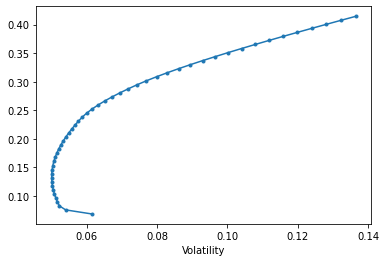

In [ ]:
# efficient frontier de ces actifs 
l = ["Smoke", "Fin", "Games", "Coal"]
fct.plot_ef(50, er[l], cov.loc[l,l])

In [ ]:
# Verification  
W15 = fct.minimize_vol(0.15 , er[l] , cov.loc[l,l]) # les poids 
vol = fct.portfolio_vol(W15 , cov.loc[l,l]) # verif volatility (la courbe) 
vol

0.05034422565993661

In [ ]:
W15  # les poids

array([0.24152012, 0.27457601, 0.39842497, 0.0854789 ])

# Finding the Max Sharpe Ratio Portfolio

Nous avons déjà vu qu'étant donné un ensemble de rendements attendus et une matrice de covariance, nous pouvons tracer la frontière efficiente. Dans cette section, nous allons étendre le code pour localiser le point sur la frontière efficiente qui nous intéresse le plus, c'est-à-dire le portefeuille de tangence ou le portefeuille Max Sharpe Ratio.


Nous savons déjà identifier les points sur la courbe si on nous donne un taux de rendement cible. Au lieu de minimiser le vol en fonction d'un rendement cible, nous voulons trouver ce point sur la courbe qui maximise le ratio de Sharpe, compte tenu du taux sans risque.

```python
def msr(riskfree_rate, er, cov):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio
        of the given portfolio
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol
    
    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x
```


(0.0, 0.14178366279799037)

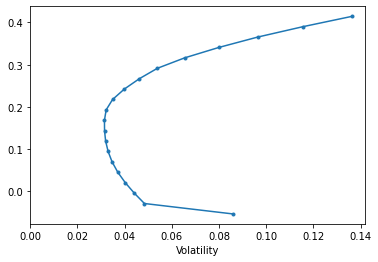

In [ ]:
ax = fct.plot_ef(20, er, cov)
ax.set_xlim(left = 0)

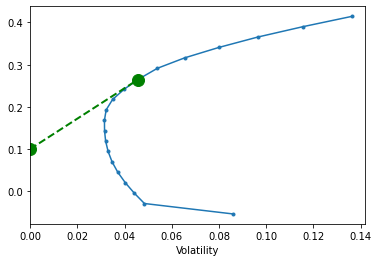

In [ ]:
# plot EF
ax = fct.plot_ef(20, er, cov)
ax.set_xlim(left = 0)
# get MSR
rf = 0.1
w_msr = fct.msr(rf, er, cov) #poids en utilisant msr
r_msr = fct.portfolio_return(w_msr, er) #RENDEMENT MSR
vol_msr = fct.portfolio_vol(w_msr, cov)  #Volatility MSR
# add CML  ligne du capital du marché 
cml_x = [0, vol_msr]
cml_y = [rf, r_msr]
ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)

In [ ]:
r_msr, vol_msr

(0.26473948288033194, 0.04571973231103104)



```python
    if show_cml:
        ax.set_xlim(left = 0)
        # get MSR
        w_msr = msr(riskfree_rate, er, cov)
        r_msr = portfolio_return(w_msr, er)
        vol_msr = portfolio_vol(w_msr, cov)
        # add CML
        cml_x = [0, vol_msr]
        cml_y = [riskfree_rate, r_msr]
        # ligne du marché des capitaux
        ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)
```


# Let's look at a simple 2-asset portfolio and find the optimal weights if we had known what the returns would be.

In [ ]:
l = ["Food", "Steel"]
import numpy as np
fct.msr(0.1, np.array(er[l]), cov.loc[l,l])

array([0.75040362, 0.24959638])

Une façon d'éviter ce jeu d'estimation est de sauter tout le processus et de se fier uniquement à la diversification naïve, ce qui signifie détenir toutes les actions avec un poids égal.

```python
    if show_ew:
        n = er.shape[0]
        w_ew = np.repeat(1/n, n)
        r_ew = portfolio_return(w_ew, er)
        vol_ew = portfolio_vol(w_ew, cov)
        # add EW
        ax.plot([vol_ew], [r_ew], color='goldenrod', marker='o', markersize=10)
```

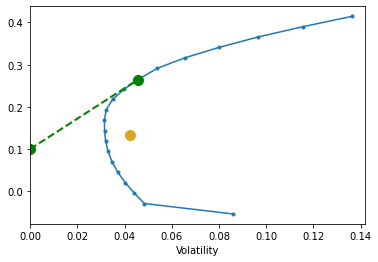

In [ ]:
fct.plot_ef(20, er, cov, show_cml=True, riskfree_rate=0.1, show_ew=True)

**GMV**

Les chercheurs ont montré que le portefeuille EW est un portefeuille remarquablement bon à détenir. En fait, l'idée qu'il s'agit d'un portefeuille bien meilleur à détenir qu'un équivalent pondéré en fonction de la capitalisation boursière est largement soutenue. Nous examinerons cela dans les sections suivantes, mais comme vous pouvez le constater, le portefeuille EW est bien à l'intérieur de la frontière efficiente, mais il ne nécessite aucune estimation.

Cependant, il y a un autre point sur la frontière efficiente qui est très intéressant. C'est le _nez_ de la coque, qui est le portefeuille de volatilité la plus faible parmi tous les portefeuilles possibles. C'est ce qu'on appelle le portefeuille à volatilité minimale ou Global Minimum Volatility ou GMV.

comment trouve les poids du portefeuille GMV ?

La chose intéressante à ce sujet est que si vous supposez que tous les rendements sont les mêmes, l'optimiseur ne peut pas améliorer le ratio de sharpe en augmentant les rendements, et il doit donc le faire en réduisant la volatilité. Cela signifie que si nous sautons simplement toute estimation des rendements et supposons que tous les rendements ont le rendement, nous obtiendrons les pondérations du portefeuille GMV 

```python
def gmv(cov):
    """
    Returns the weights of the Global Minimum Volatility portfolio
    given a covariance matrix
    """
    n = cov.shape[0]
    return msr(0, np.repeat(1, n), cov)
```



```python
    if show_gmv:
        w_gmv = gmv(cov)
        r_gmv = portfolio_return(w_gmv, er)
        vol_gmv = portfolio_vol(w_gmv, cov)
        # add EW
        ax.plot([vol_gmv], [r_gmv], color='midnightblue', marker='o', markersize=10)
```

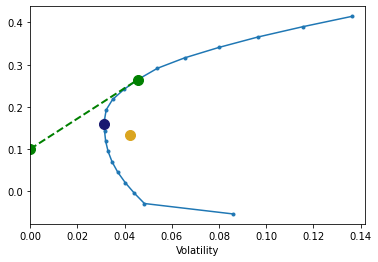

In [ ]:
fct.plot_ef(20, er, cov, show_cml=True, riskfree_rate=0.1, show_ew=True, show_gmv=True)

# Limits of Diversification


La raison en est que les corrélations entre les actifs augmentent à mesure que le marché baisse. 

# Implementer Cap-Weighted Portfolio

La plupart des indices boursiers sont construits en prenant un ensemble d'actifs et en les pondérant par leur valeur boursière, c'est-à-dire la capitalisation boursière.

Construisons un indice pondéré par la capitalisation boursière à partir de nos 30 portefeuilles sectoriels.

Pour chacune de ces industries, nous avons également des données sur le nombre d'actions dans chaque industrie ainsi que la capitalisation boursière moyenne dans chaque industrie. Ainsi, nous pouvons multiplier la capitalisation boursière moyenne par le nombre d'entreprises pour obtenir la capitalisation boursière totale de chaque industrie. Nous pouvons ensuite pondérer chaque portefeuille sectoriel proportionnellement à la capitalisation boursière de ce secteur.

Chargeons la taille de l'industrie et le nombre moyen d'entreprises :
```python

le nombres d'entreprises dans chaque secteur
def get_ind_nfirms():
    """
    Load and format the Ken French 30 Industry Portfolios Average number of Firms
    """
    ind = pd.read_csv("data/ind30_m_nfirms.csv", header=0, index_col=0)
    ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')
    ind.columns = ind.columns.str.strip()
    return ind

taille de l'entreprise
def get_ind_size():
    """
    Load and format the Ken French 30 Industry Portfolios Average size (market cap)
    """
    ind = pd.read_csv("data/ind30_m_size.csv", header=0, index_col=0)
    ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')
    ind.columns = ind.columns.str.strip()
    return ind
```


```python

import pandas as pd

def get_ind_nfirms():
    """
    Load and format the Ken French 30 Industry Portfolios Average number of Firms
    """
    ind = pd.read_csv("data/ind30_m_nfirms.csv", header=0, index_col=0)
    ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')
    ind.columns = ind.columns.str.strip()
    return ind

def get_ind_size():
    """
    Load and format the Ken French 30 Industry Portfolios Average size (market cap)
    """
    ind = pd.read_csv("data/ind30_m_size.csv", header=0, index_col=0)
    ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')
    ind.columns = ind.columns.str.strip()
    return ind
```


In [ ]:
ind_nfirms = fct.get_ind_nfirms()
ind_size = fct.get_ind_size()


In [ ]:
ind_nfirms.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,43,3,16,7,2,8,12,7,17,13,...,5,3,7,6,74,2,33,6,12,4
1926-08,43,3,16,7,2,8,12,7,17,13,...,5,3,7,6,74,2,33,6,12,4
1926-09,43,3,16,7,2,8,12,7,17,13,...,5,3,7,6,74,2,33,6,12,4
1926-10,43,3,16,7,2,8,12,7,17,13,...,5,3,7,6,74,2,33,6,12,4
1926-11,43,3,16,7,2,8,12,7,17,13,...,5,3,7,6,74,2,33,6,12,4


In [ ]:
ind_size.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,35.98,7.12,59.72,26.41,12.02,22.27,18.36,25.52,57.59,6.18,...,350.36,13.60,56.70,35.35,66.91,1.19,46.65,10.82,18.83,24.25
1926-08,36.10,6.75,60.47,27.17,13.33,22.13,19.83,25.80,62.13,6.20,...,353.27,14.75,57.74,37.86,67.99,0.90,46.57,11.00,18.88,25.51
1926-09,37.00,8.58,64.03,27.30,14.67,21.18,19.29,26.73,65.53,6.71,...,360.96,15.05,59.61,36.82,71.02,0.95,46.11,10.94,19.67,27.21
1926-10,37.14,8.92,64.42,28.76,14.42,21.23,19.03,26.87,68.47,6.82,...,364.16,15.30,59.52,34.77,70.83,0.88,46.15,10.80,19.36,26.16
1926-11,35.88,8.62,65.08,27.38,15.79,20.14,19.03,26.54,65.06,6.84,...,363.74,14.89,58.74,32.80,68.75,0.74,45.03,10.33,18.35,23.94


In [ ]:
# taille de la matrice des rendements de chaque secteur
ind.shape

(1110, 30)

In [ ]:
#taille de la matrice des moyennes des nb d'entreprises de chaque secteur
ind_nfirms.shape

In [ ]:
#taille de la matrice des tailles des entreprises de chaque secteur 
ind_size.shape

In [ ]:
#capitalisation boursiére de chaque secteur = nb d'entreprise * taille moyenne
ind_mktcap = ind_nfirms * ind_size 

In [ ]:
#taille de la matrice capitalisation boursiere 
ind_mktcap.shape

(1110, 30)

Maintenant que nous avons les capitalisations boursières pour chaque mois, nous pouvons calculer la capitalisation boursière totale au fil du temps en additionnant toutes les industries :

In [ ]:
# capitalisation boursiére totale / capitamisation du marché = somme des capitalisations de chaque secteur
total_mktcap = ind_mktcap.sum(axis=1)

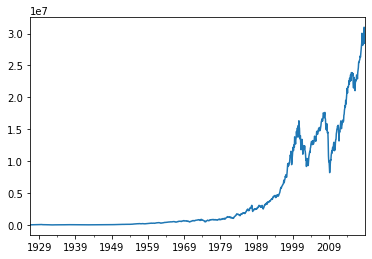

In [ ]:
total_mktcap.plot()

De toute évidence, le marché s'est développé au fil du temps. Nous pouvons maintenant calculer le poids plafond de chaque industrie comme suit :





In [ ]:
#poids de chaque secteur = capitalisation boursiére de chaque secteur / capiatlisation bousriere totale 
# output en % : partie du cap market
ind_capweight = ind_mktcap.divide(total_mktcap, axis="rows")

In [ ]:
all(abs(ind_capweight.sum(axis="columns") - 1) < 1E-10)

True

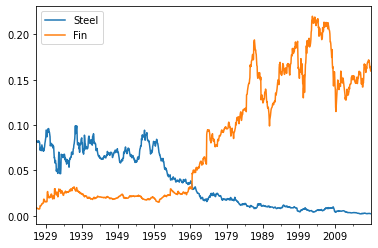

In [ ]:
ind_capweight[["Steel", "Fin"]].plot()

# Constructing a Cap Weighted Market Index

onstruire un indice de marché consiste à construire un portefeuille dont les pondérations sont rééquilibrées vers les pondérations cibles à chaque période. En réalité, les poids peuvent dériver dans le temps mais cette simplification est assez proche.

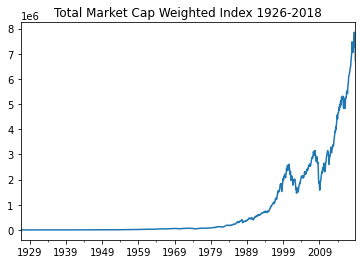

In [ ]:
#rendement totale de l'indice du marché
total_market_return = (ind_capweight * ind).sum(axis="columns")
#l'indice du marché totale
total_market_index = fct.drawdown(total_market_return).Wealth
total_market_index.plot(title="Total Market Cap Weighted Index 1926-2018")


```python
def get_total_market_index_returns():
    """
    Load the 30 industry portfolio data and derive the returns of a capweighted total market index
    """
    ind_nfirms = get_ind_nfirms()
    ind_size = get_ind_size()
    ind_return = get_ind_returns()
    ind_mktcap = ind_nfirms * ind_size
    total_mktcap = ind_mktcap.sum(axis=1)
    ind_capweight = ind_mktcap.divide(total_mktcap, axis="rows")
    total_market_return = (ind_capweight * ind_return).sum(axis="columns")
    return total_market_return

```    

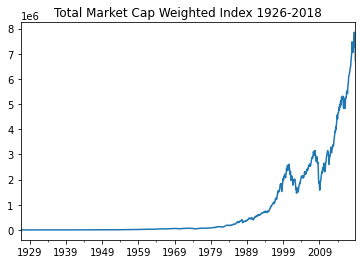

In [ ]:
total_market_return = fct.get_total_market_index_returns()
total_market_index = fct.drawdown(total_market_return).Wealth
total_market_index.plot(title="Total Market Cap Weighted Index 1926-2018")

# Rolling Windows
Pandas contient un support direct pour les fenêtres roulantes et vous permet d'agréger les retours sur une fenêtre. Dans notre cas, calculons le rendement moyen sur une fenêtre de 36 mois.

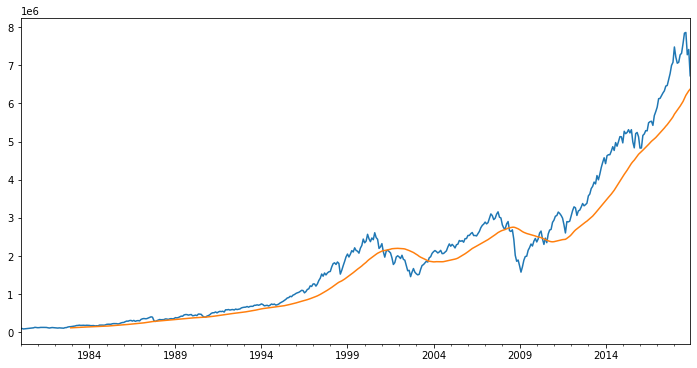

In [ ]:
total_market_index["1980":].plot(figsize=(12, 6))
#moyenne de l'indice de 36 mois 
total_market_index["1980":].rolling(window=36).mean().plot()

Nous ne voulons pas vraiment le rendement moyen, nous voulons regarder le rendement composé sur 3 ans. Nous devons appliquer notre propre fonction, au lieu de `mean()`.

Chaque fois que la fenêtre est avancée, un nouveau DataFrame (avec juste la tranche du DataFrame dans la fenêtre) est utilisé pour générer une nouvelle valeur. Vous pouvez soit utiliser l'une des méthodes DataFrame intégrées comme `.mean` ou vous pouvez utiliser la méthode `.aggregate` pour appliquer votre propre fonction à chaque colonne pour toutes les lignes qui tombent dans cette fenêtre.

Créons une série chronologique des rendements annualisés sur les 36 derniers mois et la corrélation moyenne entre les actions sur ces mêmes 36 mois.

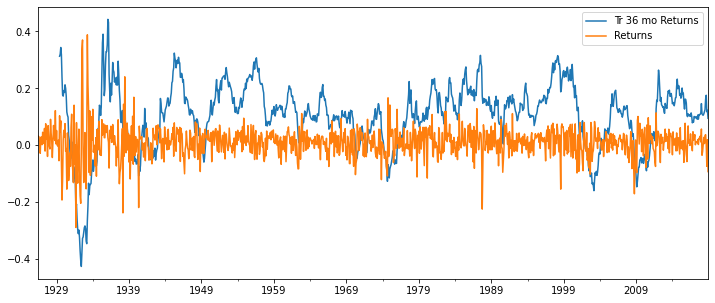

In [ ]:
#additionner les rendements au fil du temps
#regrouper chacune de ces fenetres de 36 mois
#les rendements de 36 mois
tmi_tr36rets = total_market_return.rolling(window=36).aggregate(fct.annualize_rets, periods_per_year=12)
tmi_tr36rets.plot(figsize=(12,5), label="Tr 36 mo Returns", legend=True)
#les renddements reels (actual returns)
total_market_return.plot(label="Returns", legend=True)

# Rolling Correlations: Multi Indexes and `.groupby`



In [ ]:
# corrélation entre les inductries 
ts_corr = ind.rolling(window=36).corr()
ts_corr.tail()
# Output : time series de matrice non de chiifre 
# chaque période a une matrice de corr = multi index 

Food      Beer     Smoke     Games     Books     Hshld  \
2018-12 Whlsl  0.474948  0.356983  0.122672  0.510425  0.803362  0.419280   
        Rtail  0.517856  0.406107  0.030283  0.676464  0.636320  0.358336   
        Meals  0.370187  0.385483  0.122007  0.301516  0.520649  0.308216   
        Fin    0.298823  0.192706  0.027593  0.480276  0.694812  0.162690   
        Other  0.436952  0.376565  0.224010  0.331829  0.558072  0.390610   

                  Clths      Hlth     Chems     Txtls  ...     Telcm  \
2018-12 Whlsl  0.570071  0.739764  0.785796  0.634197  ...  0.648092   
        Rtail  0.676598  0.714933  0.626034  0.634202  ...  0.562238   
        Meals  0.302176  0.416193  0.520023  0.491726  ...  0.406184   
        Fin    0.425899  0.658468  0.760151  0.577090  ...  0.420863   
        Other  0.467099  0.645035  0.712511  0.520953  ...  0.607868   

                  Servs     BusEq     Paper     Trans     Whlsl     Rtail  \
2018-12 Whlsl  0.567395  0.543362  0.764252  0.829185  1.000000  0.744842   
        Rtail  0.762616  0.628246  0.656510  0.630615  0.744842  1.000000   
        Meals  0.444629  0.399438  0.627113  0.663358  0.643879  0.616947   
        Fin    0.585418  0.517947  0.670936  0.760730  0.746480  0.611883   
        Other  0.460322  0.434487  0.773798  0.756961  0.767652  0.619918   

                  Meals       Fin     Other  
2018-12 Whlsl  0.643879  0.746480  0.767652  
        Rtail  0.616947  0.611883  0.619918  
        Meals  1.000000  0.502563  0.605226  
        Fin    0.502563  1.000000  0.734837  
        Other  0.605226  0.734837  1.000000  

[5 rows x 30 columns]

In [ ]:
ts_corr.index.names = ['date', 'industry']
ts_corr.tail()

Food      Beer     Smoke     Games     Books     Hshld  \
date    industry                                                               
2018-12 Whlsl     0.474948  0.356983  0.122672  0.510425  0.803362  0.419280   
        Rtail     0.517856  0.406107  0.030283  0.676464  0.636320  0.358336   
        Meals     0.370187  0.385483  0.122007  0.301516  0.520649  0.308216   
        Fin       0.298823  0.192706  0.027593  0.480276  0.694812  0.162690   
        Other     0.436952  0.376565  0.224010  0.331829  0.558072  0.390610   

                     Clths      Hlth     Chems     Txtls  ...     Telcm  \
date    industry                                          ...             
2018-12 Whlsl     0.570071  0.739764  0.785796  0.634197  ...  0.648092   
        Rtail     0.676598  0.714933  0.626034  0.634202  ...  0.562238   
        Meals     0.302176  0.416193  0.520023  0.491726  ...  0.406184   
        Fin       0.425899  0.658468  0.760151  0.577090  ...  0.420863   
        Other     0.467099  0.645035  0.712511  0.520953  ...  0.607868   

                     Servs     BusEq     Paper     Trans     Whlsl     Rtail  \
date    industry                                                               
2018-12 Whlsl     0.567395  0.543362  0.764252  0.829185  1.000000  0.744842   
        Rtail     0.762616  0.628246  0.656510  0.630615  0.744842  1.000000   
        Meals     0.444629  0.399438  0.627113  0.663358  0.643879  0.616947   
        Fin       0.585418  0.517947  0.670936  0.760730  0.746480  0.611883   
        Other     0.460322  0.434487  0.773798  0.756961  0.767652  0.619918   

                     Meals       Fin     Other  
date    industry                                
2018-12 Whlsl     0.643879  0.746480  0.767652  
        Rtail     0.616947  0.611883  0.619918  
        Meals     1.000000  0.502563  0.605226  
        Fin       0.502563  1.000000  0.734837  
        Other     0.605226  0.734837  1.000000  

[5 rows x 30 columns]

In [ ]:
# group by date 
# chaque date a une moyenne de la matrice de corr 
ind_tr36corr = ts_corr.groupby(level='date').apply(lambda cormat: cormat.values.mean())

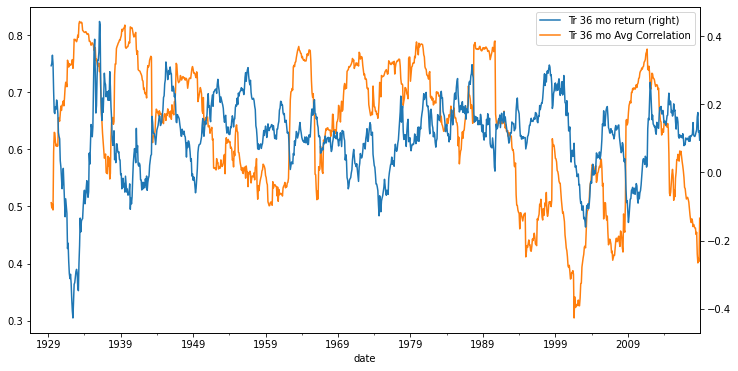

In [ ]:
# secondary_y : deux axes de y ( erturn and corr)
tmi_tr36rets.plot(secondary_y=True, legend=True, label="Tr 36 mo return", figsize=(12,6))
ind_tr36corr.plot(legend=True, label="Tr 36 mo Avg Correlation")

Interpretation :
lorsque le marché diminue , les corrélations augmentent

In [ ]:
# la corrélation entre la corrélatin moyenne des industries
tmi_tr36rets.corr(ind_tr36corr)

ces deux séries sont négativement corrélées, ce qui explique pourquoi la diversification vous échoue lorsque vous en avez le plus besoin. Lorsque les marchés chutent, les corrélations augmentent, ce qui rend la diversification beaucoup moins précieuse.

Au lieu de cela, nous verrons comment utiliser l'assurance pour protéger les risques.

# Implementing Portfolio Insurance (CPPI) and Drawdown Constraints

Implementer l'algorithme de base de budgétisation dynamique des risques de l'assurance de portefeuille à proportion constante et le tester par rapport à différents portefeuilles.


In [ ]:
tmi_return = fct.get_total_market_index_returns()

 prend en entrée les rendements d'un actif risqué et d'un actif sûr, ainsi que la richesse initiale à investir au départ, ainsi qu'un plancher à ne pas franchir.



1. Calculer le coussin (valeur de l'actif moins plancher)
2. Calculer l'allocation ( m*risky_asset)
3. Recalculer la nouvelle valeur de l'actif en fonction des rendements



```python

def run_cppi(risky_r, safe_r=None, m=3, start=1000, floor=0.8, riskfree_rate=0.03, drawdown=None):
    """
    Run a backtest of the CPPI strategy, given a set of returns for the risky asset
    Returns a dictionary containing: Asset Value History, Risk Budget History, Risky Weight History
    """
    # set up the CPPI parameters
    dates = risky_r.index
    n_steps = len(dates)
    account_value = start
    floor_value = start*floor
    peak = account_value
    if isinstance(risky_r, pd.Series): 
        risky_r = pd.DataFrame(risky_r, columns=["R"])

    if safe_r is None:
        safe_r = pd.DataFrame().reindex_like(risky_r)
        safe_r.values[:] = riskfree_rate/12 # fast way to set all values to a number
    # set up some DataFrames for saving intermediate values
    account_history = pd.DataFrame().reindex_like(risky_r)
    risky_w_history = pd.DataFrame().reindex_like(risky_r)
    cushion_history = pd.DataFrame().reindex_like(risky_r)
    floorval_history = pd.DataFrame().reindex_like(risky_r)
    peak_history = pd.DataFrame().reindex_like(risky_r)

    for step in range(n_steps):
        if drawdown is not None:
            peak = np.maximum(peak, account_value)
            floor_value = peak*(1-drawdown)
        cushion = (account_value - floor_value)/account_value
        risky_w = m*cushion
        risky_w = np.minimum(risky_w, 1)
        risky_w = np.maximum(risky_w, 0)
        safe_w = 1-risky_w
        risky_alloc = account_value*risky_w
        safe_alloc = account_value*safe_w
        # recompute the new account value at the end of this step
        account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
        # save the histories for analysis and plotting
        cushion_history.iloc[step] = cushion
        risky_w_history.iloc[step] = risky_w
        account_history.iloc[step] = account_value
        floorval_history.iloc[step] = floor_value
        peak_history.iloc[step] = peak
    risky_wealth = start*(1+risky_r).cumprod()
    backtest_result = {
        "Wealth": account_history,
        "Risky Wealth": risky_wealth, 
        "Risk Budget": cushion_history,
        "Risky Allocation": risky_w_history,
        "m": m,
        "start": start,
        "floor": floor,
        "risky_r":risky_r,
        "safe_r": safe_r,
        "drawdown": drawdown,
        "peak": peak_history,
        "floor": floorval_history
    }
    return backtest_result

```    



ValueError: ignored

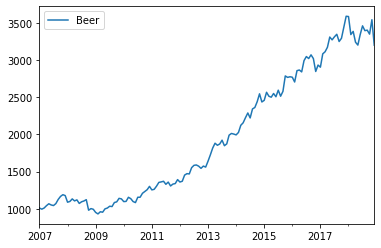

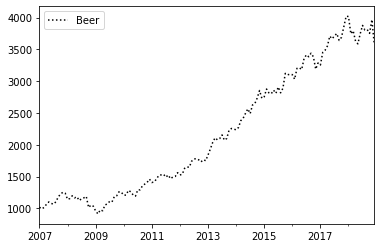

In [ ]:

btr= fct.run_cppi(ind["2007":][["Beer"]])
ax = btr["Wealth"].plot()
btr["Risky Wealth"].plot(style="k:")
Floor = btr["floor"]
ax.axhline(y=Floor, color='r', linestyle='--')

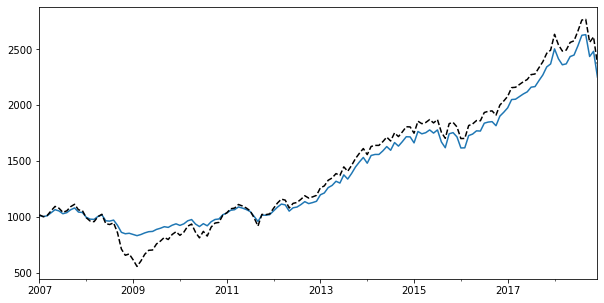

In [ ]:
btr2 = fct.run_cppi(tmi_return["2007":])
ax = btr2["Wealth"].plot(legend=False, figsize=(10, 5))
btr2["Risky Wealth"].plot(ax = ax, style="k--", legend=False)

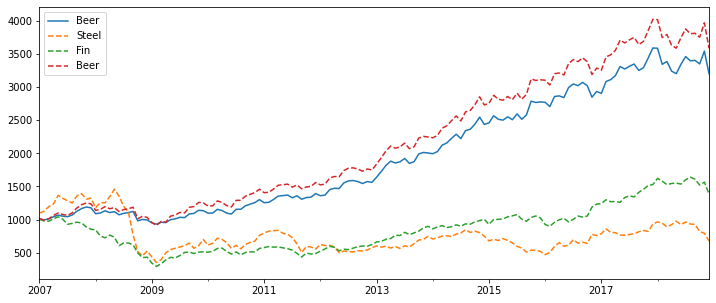

In [ ]:
btr3 = fct.run_cppi(ind["2007":][["Steel", "Fin", "Beer"]])  # les resultats du backtest
ax = btr["Wealth"].plot(figsize=(12,5)) 
btr3["Risky Wealth"].plot(ax=ax, style="--")

```python

def summary_stats(r, riskfree_rate=0.03):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
    """
    ann_r = r.aggregate(annualize_rets, periods_per_year=12)
    ann_vol = r.aggregate(annualize_vol, periods_per_year=12)
    ann_sr = r.aggregate(sharpe_ratio, riskfree_rate=riskfree_rate, periods_per_year=12)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    skew = r.aggregate(skewness)
    kurt = r.aggregate(kurtosis)
    cf_var5 = r.aggregate(var_gaussian, modified=True)
    hist_cvar5 = r.aggregate(cvar_historic)
    return pd.DataFrame({
        "Annualized Return": ann_r,
        "Annualized Vol": ann_vol,
        "Skewness": skew,
        "Kurtosis": kurt,
        "Cornish-Fisher VaR (5%)": cf_var5,
        "Historic CVaR (5%)": hist_cvar5,
        "Sharpe Ratio": ann_sr,
        "Max Drawdown": dd
    })

```

In [ ]:
fct.summary_stats(btr3["Wealth"].pct_change().dropna())  # convertir btr en des rendements 
# richesse de CPPI
# l'indice du marché total a chuté d'environ 40 % dans steel ( max drawdown)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.014490,0.126906,-1.554266,11.668243,0.068652,0.004543,-0.341351,-0.404132
Fin,0.054690,0.109579,-0.254976,5.589082,0.047503,0.000311,0.219159,-0.216868
Beer,0.101518,0.114363,-0.743585,4.527865,0.051074,0.001146,0.608531,-0.217280


In [ ]:
fct.summary_stats(btr3["Risky Wealth"].pct_change().dropna())
# richesse ss CPPI

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.459951,4.782828,0.152288,0.009735,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.695200,4.621401,0.105744,-0.000156,-0.012370,-0.718465
Beer,0.111554,0.127971,-0.670797,4.650878,0.056497,-0.000083,0.620132,-0.271368


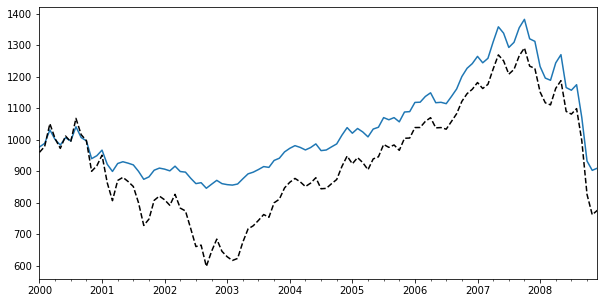

In [ ]:
btr4 = fct.run_cppi(tmi_return["2000":"2008"])
ax = btr4["Wealth"].plot(legend=False, figsize=(10, 5))
btr4["Risky Wealth"].plot(ax = ax, style="k--", legend=False)